In [43]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles,venn3, venn3_circles, venn3_unweighted
import pandas as pd
from functools import reduce
import os
import re
from pathlib import Path

import urllib.parse
import urllib.request

In [65]:
def foward_look(value):
    p = re.compile('.+(?=\\.)')
    m = p.search(value)
    return m.group()

def uniprot_retrieve(ensembl):    
#     ensembl_query = "\t".join(list(map(foward_look, ensembl)))
    ensembl_query = "\t".join(ensembl)
    
    url = 'https://www.uniprot.org/uploadlists/'
    params = {
    'from': 'ENSEMBL_PRO_ID',
    'to': 'ID',
    'format': 'tab',
    'query' : ''
    }
    
    params["query"] = ensembl_query
    
    # uniprotKB
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        
    UniProtKB_ID = list(map(lambda x : x.split('\t'), response.decode('utf-8').split('\n')))[1:-1] # first - last row 
    UniProtKB_ID = pd.DataFrame(UniProtKB_ID)
    UniProtKB_ID.columns = ["proteinB", "UniProtKB_ID"]
    
    params["to"] = "SWISSPROT"
    #swissprot
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        
    SWISSPROT = list(map(lambda x : x.split('\t'), response.decode('utf-8').split('\n')))[1:-1] # first - last row 
    SWISSPROT = pd.DataFrame(SWISSPROT)
    SWISSPROT.columns = ["proteinB", "SWISSPROT"]
    
    return pd.merge(UniProtKB_ID, SWISSPROT, on = "proteinB")

### **PATH**

In [54]:
BASE_PATH = "/home/km/gitworking/ppi_prediction/"
PIPR_RESULT = BASE_PATH + "PIPR/RESULT/" + "20220321-134452_predictions.tsv"
DEEPTRIO_RESULT = BASE_PATH + "DeepTrio/RESULT/" + "DeepTrio-Result"
DSCRIPT_RESULT = BASE_PATH + "D-SCRIPT/" + "IGSF1_RESULT/"
PP_RESULT = BASE_PATH + "ProteinPrompt/" + "IGSF1.txt"
OUT = BASE_PATH + "RESULT/"
Path(OUT).mkdir(parents=True, exist_ok=True)

### **PIPR**

In [95]:
# PIPR
pipr_result = pd.read_csv(PIPR_RESULT, delimiter="\t")
pipr_result.columns = ["pairs", "True", "False"]

pipr_df = pipr_result['pairs'].str.split('-', expand=True)
pipr_df[["True"]] = pipr_result[["True"]]
pipr_df.columns = ["proteinA", "proteinB", "probability"]
pipr_df['proteinB'] = list(map(foward_look, pipr_df['proteinB'].to_list()))

mapping_df = uniprot_retrieve(pipr_df.proteinB.to_list())
PIPR_df = pd.merge(mapping_df, pipr_df, on='proteinB', how = "inner")

In [96]:
pipr = set(PIPR_df[PIPR_df.probability > 0.9].loc[:, "SWISSPROT"].to_list())

len(pipr)

891

### **DeepTrio**

In [88]:
deeptrio_df = pd.read_csv(DEEPTRIO_RESULT, sep="\t", index_col=False).iloc[:, :3]
deeptrio_df.columns = ["proteinA", "proteinB", "probability"]
deeptrio_df['proteinB'] = list(map(foward_look, deeptrio_df['proteinB'].to_list()))

mapping_df = uniprot_retrieve(deeptrio_df.proteinB.to_list())
DeepTrio_df = pd.merge(mapping_df, deeptrio_df, on='proteinB', how = "inner")

In [92]:
deeptrio = set(DeepTrio_df[DeepTrio_df.probability > 0.9].loc[:, "SWISSPROT"].to_list())

len(deeptrio)

79

### **ProteinPrompt**

In [100]:
pp_df = pd.read_csv(PP_RESULT, sep="\t", index_col=False, header=None)
pp_df.columns = ['protein', 'probability', 'N', 'SWISSPROT']

In [101]:
pp_df

,protein,probability,N,SWISSPROT
0,1433B,0.9985,0.0015,P31946
1,1433E,0.4419,0.5581,P62258
2,1433F,0.9981,0.0019,Q04917
3,1433G,0.9985,0.0015,P61981
4,1433S,0.9965,0.0035,P31947
...,...,...,...,...
27218,ZY11A,0.1907,0.8093,Q6WRX3
27219,ZY11B,0.0881,0.9119,Q9C0D3
27220,ZYX,0.0144,0.9856,Q15942
27221,ZZEF1,0.0041,0.9959,O43149


### **D-SCRIPT**

In [38]:
dscript_list = []

for (root, directories, files) in os.walk(DSCRIPT_RESULT):
    for file in files:
        if 'positive.tsv' in file:
            file_path = os.path.join(root, file)
            try:
                dscript_list.append(pd.read_csv(file_path, sep='\t', header=None))
            except:
                print("no Positive interaction")

no Positive interaction
no Positive interaction
no Positive interaction
no Positive interaction


In [79]:
dscript_df = reduce(lambda x, y : pd.concat([x,y]), dscript_list)
dscript_df.columns = ["proteinA", "proteinB", "probability"]
dscript_df['proteinB'] = list(map(foward_look, dscript_df['proteinB'].to_list()))

mapping_df = uniprot_retrieve(dscript_df.proteinB.to_list())
DSCRIPT_df = pd.merge(mapping_df, dscript_df, on='proteinB', how = "inner")

In [87]:
dscript = set(DSCRIPT_df.SWISSPROT.to_list())

### **Ven diagram**

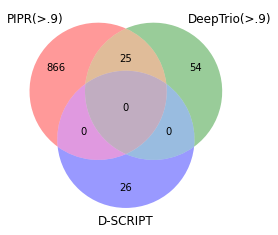

In [98]:
v = venn3_unweighted(subsets=[pipr, deeptrio, dscript], set_labels=('PIPR(>.9)', 'DeepTrio(>.9)', 'D-SCRIPT'), )

### **Result Writing**

* **PIPR DeepTrio**

In [27]:
PIPR_DeepTrio_intersection = list(pipr & deeptrio)
PIPR_DeepTrio_df = pd.merge(pipr_df, deeptrio_df, on=['proteinA','proteinB'], suffixes=["_PIPR", "_DeepTrio"],how="inner")
PIPR_DeepTrio_df = PIPR_DeepTrio_df[PIPR_DeepTrio_df['proteinB'].isin(PIPR_DeepTrio_intersection)].reset_index(drop=True)

In [48]:
PIPR_DeepTrio.to_csv(OUT + "PIPR_DeepTrio_intersection.csv", sep=",", index=None)

* **D-SCRIPT**

In [53]:
mapping_df = uniprot_retrieve(dscript_df.proteinB.to_list())
DSCRIPT_df = pd.merge(mapping_df, dscript_df, on='proteinB', how = "inner")

DSCRIPT_df.to_csv(OUT + "D-SCRIPT.csv", sep=",", index=None)

In [75]:
pipr

{'ENSP00000341280',
 'ENSP00000282470',
 'ENSP00000309790',
 'ENSP00000424402',
 'ENSP00000509662',
 'ENSP00000378721',
 'ENSP00000362283',
 'ENSP00000404705',
 'ENSP00000405068',
 'ENSP00000399709',
 'ENSP00000405987',
 'ENSP00000509891',
 'ENSP00000489770',
 'ENSP00000494766',
 'ENSP00000502984',
 'ENSP00000338093',
 'ENSP00000242108',
 'ENSP00000371308',
 'ENSP00000492761',
 'ENSP00000460236',
 'ENSP00000359292',
 'ENSP00000258991',
 'ENSP00000332536',
 'ENSP00000376955',
 'ENSP00000011619',
 'ENSP00000494067',
 'ENSP00000249923',
 'ENSP00000494732',
 'ENSP00000297788',
 'ENSP00000342434',
 'ENSP00000440045',
 'ENSP00000362774',
 'ENSP00000431821',
 'ENSP00000358596',
 'ENSP00000264596',
 'ENSP00000499951',
 'ENSP00000378578',
 'ENSP00000489535',
 'ENSP00000364150',
 'ENSP00000403040',
 'ENSP00000422106',
 'ENSP00000340271',
 'ENSP00000383402',
 'ENSP00000398470',
 'ENSP00000494638',
 'ENSP00000261023',
 'ENSP00000362646',
 'ENSP00000449273',
 'ENSP00000321195',
 'ENSP00000507800',
